## **Model Catboost**
**1. Loading train_v2 ** <br>
**2. Loading train ** <br>
**3. Merging train_v2 and train** <br>
**4. Loading test ** <br>
**5. Choosing features ** <br>
**6. Model Catboost ** <br>
**7. Feature importance ** <br>

In [1]:
import pandas as pd
import catboost
import numpy as np
import gc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def change_datatype_numeric(df):
    int_cols = list(df.select_dtypes(include=['int64','int32','int16']).columns)
    df[int_cols] = df[int_cols].apply(pd.to_numeric,downcast='unsigned')
    
    float_cols = list(df.select_dtypes(include=['float']).columns)
    df[float_cols] = df[float_cols].apply(pd.to_numeric,downcast='float')

## 1. Loading train_v2 

In [3]:
# loading train_v2_trans_mem
train_v2 = pd.read_csv('features\\train_v2_trans_mems.csv')
train_v2.shape

(970960, 23)

In [4]:
train_v2.head()

,msno,is_churn,city,bd,gender,registered_via,registration_init_time,registration_init_date,year,month,...,total_transactions_3m,latest_transactions,common_payment_method,number_payment_method,common_plan_days,latest_auto_renew,rate_auto_renew,latest_cancel,rate_cancel,sum_discrepancy_paid
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,5,28,male,3,20131223,2013-12-23,2013,12,...,1.0,0,31,2,0,0,0.833333,0,0.166667,-596
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,13,20,male,3,20131223,2013-12-23,2013,12,...,1.0,18,38,3,30,0,0.000000,0,0.000000,0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,13,18,male,3,20131227,2013-12-27,2013,12,...,3.0,28,38,1,30,0,0.000000,0,0.000000,0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,0,unknown,7,20140109,2014-01-09,2014,1,...,0.0,368,41,2,30,1,0.965517,1,0.103448,-298
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,13,35,female,7,20140125,2014-01-25,2014,1,...,4.0,12,41,1,30,1,1.000000,0,0.096774,-427


In [5]:
logs_1 = pd.read_csv('features\\train_v2_logs_part1.csv')
logs_1.head()


,msno,is_churn,total_day_streaming,latest_days_streaming,days_streaming_1m_1st,days_streaming_1m_2nd,days_streaming_trend,days_streaming_3m,days_streaming_6m,days_streaming_12m
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,13,610,0,0,0.0,0,0,0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,28,8,4,0,4000.0,4,4,28
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,88,20,13,0,13000.0,13,26,52
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,1,15397,0,0,0.0,0,0,0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,70,95,0,0,0.0,0,14,31


In [6]:
logs_1.drop(['msno','is_churn'],axis=1, inplace = True)
logs_1.shape


(970960, 8)

In [7]:
logs_2 = pd.read_csv('features\\train_v2_logs_part2.csv')
logs_2.head()

,msno,is_churn,num_25_1m_1st,num_25_1m_2nd,num_25_trend,num_50_1m_1st,num_50_1m_2nd,num_50_trend,num_75_1m_1st,num_75_1m_2nd,num_75_trend
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0,0,0.0,0,0,0.0,0,0,0.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,7,0,7000.0,1,0,1000.0,2,0,2000.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,78,0,78000.0,23,0,23000.0,11,0,11000.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,0,0,0.0,0,0,0.0,0,0,0.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,0,0,0.0,0,0,0.0,0,0,0.0


In [8]:
logs_2.drop(['msno','is_churn'],axis=1, inplace = True)
logs_2.shape

(970960, 9)

In [9]:
logs_3 = pd.read_csv('features\\train_v2_logs_part3.csv')
logs_3.head()

,msno,is_churn,num_985_1m_1st,num_985_1m_2nd,num_985_trend,num_100_1m_1st,num_100_1m_2nd,num_100_trend
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0,0,0.0,0,0,0.0
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,3,0,3000.0,14,0,14000.0
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,12,0,12000.0,117,0,117000.0
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,0,0,0.0,0,0,0.0
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,0,0,0.0,0,0,0.0


In [10]:
logs_3.drop(['msno','is_churn'],axis=1, inplace = True)
logs_3.shape

(970960, 6)

In [11]:
logs_4 = pd.read_csv('features\\train_v2_logs_part4.csv')
logs_4.head()

,msno,is_churn,num_unq_1m_1st,num_unq_1m_2nd,num_unq_trend,total_secs_1m_1st,total_secs_1m_2nd,total_secs_trend
0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0,0,0.0,0.00000,0.0,0.00
1,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,22,0,22000.0,76.66455,0.0,76664.55
2,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,213,0,213000.0,591.00964,0.0,591009.60
3,8iF/+8HY8lJKFrTc7iR9ZYGCG2Ecrogbc2Vy5YhsfhQ=,1,0,0,0.0,0.00000,0.0,0.00
4,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,0,0,0.0,0.00000,0.0,0.00


In [12]:
logs_4.drop(['msno','is_churn'],axis=1, inplace = True)
logs_4.shape

(970960, 6)

In [13]:
data_validation = pd.concat([train_v2,logs_1,logs_2,logs_3,logs_4],axis=1)

In [14]:

change_datatype_numeric(data_validation)
data_validation.shape

(970960, 52)

In [15]:
del train_v2, logs_1, logs_2, logs_3, logs_4
gc.collect()

25

## 2. Loading train

In [16]:
# loading train_v2_trans_mem
train = pd.read_csv('features\\train_trans_mems.csv')
train.shape

(992931, 23)

In [17]:
logs_1 = pd.read_csv('features\\train_logs_part1.csv')
logs_1.drop(['msno','is_churn'],axis=1, inplace = True)
logs_2 = pd.read_csv('features\\train_logs_part2.csv')
logs_2.drop(['msno','is_churn'],axis=1, inplace = True)
logs_3 = pd.read_csv('features\\train_logs_part3.csv')
logs_3.drop(['msno','is_churn'],axis=1, inplace = True)
logs_4 = pd.read_csv('features\\train_logs_part4.csv')
logs_4.drop(['msno','is_churn'],axis=1, inplace = True)

In [18]:
data_train = pd.concat([train,logs_1,logs_2,logs_3,logs_4],axis=1)

In [19]:
change_datatype_numeric(data_train)
data_train.shape

(992931, 52)

In [20]:
del train, logs_1, logs_2, logs_3, logs_4
gc.collect()

14

## 3. Merging train_v2 and train

In [21]:
data_train = pd.concat([data_train,data_validation],axis=0)
data_train.shape

(1963891, 52)

## 4. Loading test

In [22]:
# loading test_trans_mem
test = pd.read_csv('features\\test_trans_mems.csv')
test.shape

(907471, 23)

In [23]:
logs_1 = pd.read_csv('features\\test_logs_part1.csv')
logs_1.head()

,msno,is_churn,total_day_streaming,latest_days_streaming,days_streaming_1m_1st,days_streaming_1m_2nd,days_streaming_trend,days_streaming_3m,days_streaming_6m,days_streaming_12m
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,1,15430,0,0,0.000000,0,0,0
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,240,1,29,1,27.972028,44,71,114
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,36,3,9,4,1.249688,24,24,24
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,1,15430,0,0,0.000000,0,0,0
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,7,45,0,1,254.745255,7,7,7


In [24]:
logs_1.drop(['msno','is_churn'],axis=1, inplace = True)
logs_1.shape

(907471, 8)

In [25]:
logs_2 = pd.read_csv('features\\test_logs_part2.csv')
logs_2.head()

,msno,is_churn,num_25_1m_1st,num_25_1m_2nd,num_25_trend,num_50_1m_1st,num_50_1m_2nd,num_50_trend,num_75_1m_1st,num_75_1m_2nd,num_75_trend
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,0,0,0.000000,0,0,0.000000,0,0,0.000000e+00
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,504,15,32.597827,167,2,82.458771,115,6,1.816364e+01
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,79,54,0.462954,19,4,3.749063,1,3,1.431179e+09
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,0,0,0.000000,0,0,0.000000,0,0,0.000000e+00
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,0,0,0.000000,0,0,0.000000,0,0,0.000000e+00


In [26]:
logs_2.drop(['msno','is_churn'],axis=1, inplace = True)
logs_2.shape

(907471, 9)

In [27]:
logs_3 = pd.read_csv('features\\test_logs_part3.csv')
logs_3.head()

,msno,is_churn,num_985_1m_1st,num_985_1m_2nd,num_985_trend,num_100_1m_1st,num_100_1m_2nd,num_100_trend
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,0,0,0.000000,0,0,0.000000e+00
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,119,6,18.830195,1493,112,1.233025e+01
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,2,1,0.999001,81,54,4.999907e-01
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,0,0,0.000000,0,0,0.000000e+00
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,0,0,0.000000,0,25,1.717918e+08


In [28]:
logs_3.drop(['msno','is_churn'],axis=1, inplace = True)
logs_3.shape

(907471, 6)

In [29]:
logs_4 = pd.read_csv('features\\test_logs_part4.csv')
logs_4.head()

,msno,is_churn,num_unq_1m_1st,num_unq_1m_2nd,num_unq_trend,total_secs_1m_1st,total_secs_1m_2nd,total_secs_trend
0,4n+fXlyJvfQnTeKXTWT507Ll4JVYGrOC8LHCfwBmPE4=,0,0,0,0.000000e+00,0.00000,0.00000,0.000000
1,aNmbC1GvFUxQyQUidCVmfbQ0YeCuwkPzEdQ0RwWyeZM=,0,2034,120,1.594987e+01,7383.81840,508.14148,13.531002
2,rFC9eSG/tMuzpre6cwcMLZHEYM89xY02qcz7HL4//jc=,0,147,105,3.999962e-01,385.68576,229.97523,0.677072
3,WZ59dLyrQcE7ft06MZ5dj40BnlYQY7PHgg/54+HaCSE=,0,0,0,0.000000e+00,0.00000,0.00000,0.000000
4,aky/Iv8hMp1/V/yQHLtaVuEmmAxkB5GuasQZePJ7NU4=,0,0,23,1.867296e+08,0.00000,109.00450,-0.999991


In [30]:
logs_4.drop(['msno','is_churn'],axis=1, inplace = True)
logs_4.shape

(907471, 6)

In [31]:
data_test = pd.concat([test,logs_1,logs_2,logs_3,logs_4],axis=1)

In [32]:
change_datatype_numeric(data_test)
data_test.shape

(907471, 52)

In [33]:
del test, logs_1, logs_2, logs_3, logs_4
gc.collect()

14

In [34]:
data_test.columns

Index(['msno', 'is_churn', 'city', 'bd', 'gender', 'registered_via',
       'registration_init_time', 'registration_init_date', 'year', 'month',
       'total_transactions', 'total_transactions_12m', 'total_transactions_6m',
       'total_transactions_3m', 'latest_transactions', 'common_payment_method',
       'number_payment_method', 'common_plan_days', 'latest_auto_renew',
       'rate_auto_renew', 'latest_cancel', 'rate_cancel',
       'sum_discrepancy_paid', 'total_day_streaming', 'latest_days_streaming',
       'days_streaming_1m_1st', 'days_streaming_1m_2nd',
       'days_streaming_trend', 'days_streaming_3m', 'days_streaming_6m',
       'days_streaming_12m', 'num_25_1m_1st', 'num_25_1m_2nd', 'num_25_trend',
       'num_50_1m_1st', 'num_50_1m_2nd', 'num_50_trend', 'num_75_1m_1st',
       'num_75_1m_2nd', 'num_75_trend', 'num_985_1m_1st', 'num_985_1m_2nd',
       'num_985_trend', 'num_100_1m_1st', 'num_100_1m_2nd', 'num_100_trend',
       'num_unq_1m_1st', 'num_unq_1m_2nd', 'num_u

## 5. Choosing features

In [35]:

cols = list(data_train.columns)
cols.remove('msno')
cols.remove('is_churn')
cols.remove('gender')
cols.remove('registration_init_time')
cols.remove('registration_init_date')
cols.remove('month')


cols.remove('days_streaming_1m_1st')
cols.remove('days_streaming_1m_2nd')
cols.remove('days_streaming_6m')
cols.remove('days_streaming_3m')
cols.remove('total_day_streaming')
#cols.remove('num_25_1m_1st')
cols.remove('num_25_1m_2nd')
#cols.remove('num_25_trend')
#cols.remove('num_50_1m_1st')
cols.remove('num_50_1m_2nd')
#cols.remove('num_50_trend')
#cols.remove('num_75_1m_1st')
cols.remove('num_75_1m_2nd')
#cols.remove('num_75_trend')
#cols.remove('num_985_1m_1st')
cols.remove('num_985_1m_2nd')
#cols.remove('num_985_trend')
#cols.remove('num_100_1m_1st')
cols.remove('num_100_1m_2nd')
#cols.remove('num_100_trend')
#cols.remove('num_unq_1m_1st')
cols.remove('num_unq_1m_2nd')
#cols.remove('num_unq_trend')
#cols.remove('total_secs_1m_1st')
cols.remove('total_secs_1m_2nd')
#cols.remove('total_secs_trend')

cols.remove('total_transactions_3m')
cols.remove('total_transactions_6m')
#cols.remove('total_transactions_12m')
cols.remove('total_transactions')

In [36]:
data_train[cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963891 entries, 0 to 970959
Data columns (total 31 columns):
city                      uint8
bd                        int64
registered_via            uint8
year                      uint16
total_transactions_12m    float32
latest_transactions       uint16
common_payment_method     uint8
number_payment_method     uint8
common_plan_days          uint16
latest_auto_renew         uint8
rate_auto_renew           float32
latest_cancel             uint8
rate_cancel               float32
sum_discrepancy_paid      int64
latest_days_streaming     uint16
days_streaming_trend      float32
days_streaming_12m        uint8
num_25_1m_1st             uint16
num_25_trend              float32
num_50_1m_1st             uint16
num_50_trend              float32
num_75_1m_1st             uint16
num_75_trend              float32
num_985_1m_1st            uint16
num_985_trend             float32
num_100_1m_1st            uint16
num_100_trend             float

## 6. Model Catboost

In [38]:
# Build model

from sklearn.metrics import log_loss
cat_features=[0,2,6,9,11]
bags = 1
bagged_prediction=np.zeros(data_test.shape[0])
scores = []
for i in range(bags):
    my_random_seed = i*9 + 2012
    model = catboost.CatBoostClassifier( iterations=150, leaf_estimation_method = 'Gradient',learning_rate=0.1, random_seed=my_random_seed)
    model.fit(data_train[cols].values,data_train['is_churn'], cat_features=cat_features, eval_set=(data_validation[cols].values,data_validation['is_churn']))
    
    yhat_validation = model.predict_proba(data_validation[cols].values)
    scores.append(log_loss(data_validation['is_churn'], yhat_validation))
    
    preds=model.predict_proba(data_test[cols].values)[:,1] # predict on test data
    bagged_prediction+=preds # add predictions to bagged predictions 

#take average of predictions     
bagged_prediction/= bags 
mean, stddev = np.mean(scores), np.std(scores)
print(mean, stddev)




0:	learn: 0.5722607	test: 0.5745438	best: 0.5745438 (0)	total: 1.89s	remaining: 4m 41s
1:	learn: 0.4814087	test: 0.4857306	best: 0.4857306 (1)	total: 3.62s	remaining: 4m 27s
2:	learn: 0.4131216	test: 0.4192909	best: 0.4192909 (2)	total: 5.29s	remaining: 4m 19s
3:	learn: 0.3618878	test: 0.3696797	best: 0.3696797 (3)	total: 6.92s	remaining: 4m 12s
4:	learn: 0.3232172	test: 0.3324295	best: 0.3324295 (4)	total: 8.57s	remaining: 4m 8s
5:	learn: 0.2936805	test: 0.3041789	best: 0.3041789 (5)	total: 10.2s	remaining: 4m 4s
6:	learn: 0.2711425	test: 0.2828018	best: 0.2828018 (6)	total: 11.8s	remaining: 4m 1s
7:	learn: 0.2538054	test: 0.2664855	best: 0.2664855 (7)	total: 13.5s	remaining: 3m 59s
8:	learn: 0.2402794	test: 0.2539027	best: 0.2539027 (8)	total: 15.2s	remaining: 3m 58s
9:	learn: 0.2296273	test: 0.2440871	best: 0.2440871 (9)	total: 16.8s	remaining: 3m 55s
10:	learn: 0.2211928	test: 0.2363318	best: 0.2363318 (10)	total: 18.4s	remaining: 3m 52s
11:	learn: 0.2146227	test: 0.2304559	best: 0

93:	learn: 0.1759303	test: 0.1985797	best: 0.1985797 (93)	total: 2m 30s	remaining: 1m 29s
94:	learn: 0.1758095	test: 0.1983896	best: 0.1983896 (94)	total: 2m 31s	remaining: 1m 27s
95:	learn: 0.1757886	test: 0.1983777	best: 0.1983777 (95)	total: 2m 33s	remaining: 1m 26s
96:	learn: 0.1757418	test: 0.1983234	best: 0.1983234 (96)	total: 2m 34s	remaining: 1m 24s
97:	learn: 0.1757167	test: 0.1983060	best: 0.1983060 (97)	total: 2m 36s	remaining: 1m 22s
98:	learn: 0.1756950	test: 0.1983006	best: 0.1983006 (98)	total: 2m 37s	remaining: 1m 21s
99:	learn: 0.1756597	test: 0.1982356	best: 0.1982356 (99)	total: 2m 39s	remaining: 1m 19s
100:	learn: 0.1755700	test: 0.1980928	best: 0.1980928 (100)	total: 2m 41s	remaining: 1m 18s
101:	learn: 0.1755437	test: 0.1980676	best: 0.1980676 (101)	total: 2m 42s	remaining: 1m 16s
102:	learn: 0.1754930	test: 0.1979954	best: 0.1979954 (102)	total: 2m 44s	remaining: 1m 14s
103:	learn: 0.1754543	test: 0.1979619	best: 0.1979619 (103)	total: 2m 45s	remaining: 1m 13s
10

In [39]:
#predict = cbc.predict_proba(data_test[cols].values)[:,1]
predict = bagged_prediction


In [40]:
# Submit prediction
pd.DataFrame({'msno':data_test['msno'],'is_churn': predict}).to_csv('results/CB8_E.csv',index=False)

## 7. Feature importance

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.style.use("ggplot")
%matplotlib inline

In [42]:
feature_score = pd.DataFrame(list(zip(cols, model.get_feature_importance())), columns=['Feature','Score'])
feature_score.sort_index(by='Score', ascending=False, inplace=True)

C:\Users\kartik\AppData\Local\conda\conda\envs\kaggle\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  


In [43]:
feature_score

,Feature,Score
9,latest_auto_renew,30.377003
11,latest_cancel,16.382188
4,total_transactions_12m,10.500979
10,rate_auto_renew,7.344428
5,latest_transactions,6.580216
14,latest_days_streaming,6.336269
6,common_payment_method,4.911108
2,registered_via,4.600557
3,year,3.522654
13,sum_discrepancy_paid,2.316103


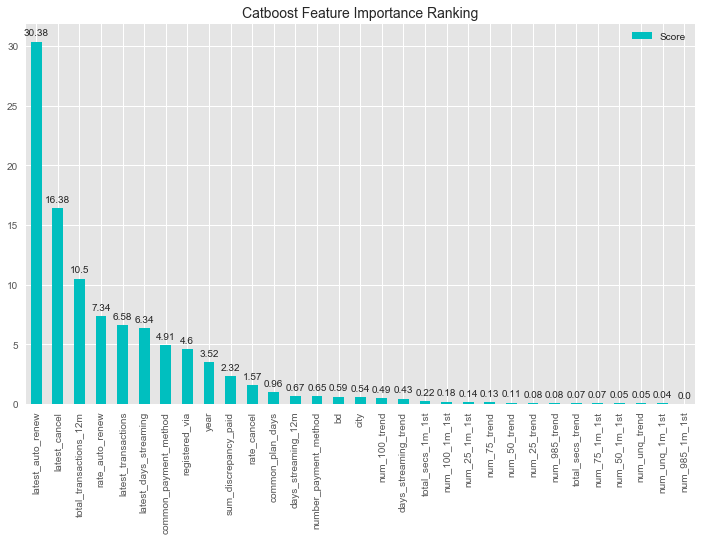

In [44]:
plt.rcParams["figure.figsize"] = (12,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

# get feature score as labels round to 2 decimal
labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()